In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

import pickle
from sklearn.decomposition import PCA

In [2]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_temporal.npy'
temporal = np.load(file)
temporal.shape #timepoint by PC

(30456, 1000)

In [3]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [4]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)
            
            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1
            
            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)
            
            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [36]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                #self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))
                self.fictrac[short].append(low_res_behavior)

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
                
            ### 10Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 100
            x_hz10 = np.arange(0,expt_len,sample_in_ms)
            hz10_res_behavior = self.pull_from_interp_object(interp_object, x_hz10)
            self.fictrac[short + '_10hz'] = hz10_res_behavior
            self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [37]:
flies = {}
for i, fly in enumerate(fly_names):
    print(F'*** fly: {fly} ***')
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()

*** fly: fly_087 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.17 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.56 sec
*** fly: fly_089 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.83 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.40 sec
*** fly: fly_094 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.46 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.47 sec
*** fly: fly_097 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.47 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.45 sec
*** fly: fly_098 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.43 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.45 sec
*** fly: fly_09

In [42]:
z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y', 'Z', 'Y_pos', 'Z_pos', 'Z_neg']
behavior_super = {}
for behavior in behaviors:
    behavior_super[behavior] = []
    for fly in fly_names:
        behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
    behavior_super[behavior] = np.asarray(behavior_super[behavior])
    behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
    if behavior in ['Y', 'Y_pos']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
    elif behavior in ['Z', 'Z_pos', 'Z_neg']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

In [6]:
# ### Pool behavior
# not_clipped_behaviors = ['Y', 'Z', 'Ya', 'Za']
# clipped_behaviors = ['Y_pos', 'Y_neg',
#                      'Z_pos', 'Z_neg',
#                      'Ya_pos', 'Ya_neg',
#                      'Za_pos', 'Za_neg']
# all_behaviors = not_clipped_behaviors + clipped_behaviors

# pooled_behavior = {}
# for j, behavior in enumerate(all_behaviors):
#     pooled_behavior[behavior] = []
#     for i,fly in enumerate(flies):
#         pooled_behavior[behavior].append(flies[fly].fictrac.fictrac[behavior])
#     pooled_behavior[behavior] = np.asarray(pooled_behavior[behavior]).flatten()

# ### Correct behavior stddev as a pooled group
# stds = {}
# for j, behavior in enumerate(not_clipped_behaviors):
#     stds[behavior] = np.std(pooled_behavior[behavior])

# for j, behavior in enumerate(all_behaviors):
#     std_key = behavior.split('_')[0] # grab not split key
#     for i,fly in enumerate(flies):
#         flies[fly].fictrac.fictrac[behavior] = flies[fly].fictrac.fictrac[behavior]/stds[std_key]
#     pooled_behavior[behavior] = pooled_behavior[behavior]/stds[std_key]

In [104]:
def bin_2D(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    #"PC" is just a holdover
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def bin_2D_plot(x_data, y_data, value_data, num_bins_x, num_bins_y, start_x, end_x, start_y, end_y, min_num_samples):
    # Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)
    #bins_x = np.concatenate((np.linspace(start_x,0,num_bins_x)[:-1], np.linspace(0,end_x,num_bins_x)))
    #bins_y = np.concatenate((np.linspace(start_y,0,num_bins_y)[:-1], np.linspace(0,end_y,num_bins_y)))
    
#     bins_x = [x / 10.0 for x in range(-20, 64, 4)]
#     bins_y = [x / 10.0 for x in range(-40, 44, 4)]
#     num_bins_x = 22
#     num_bins_y = 22
    
    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins_x), np.digitize(y_data,bins_y)

    test = bin_2D(value_data, num_bins_x, num_bins_y, idx_x ,idx_y)
    
    # Hide bins containing too few data points
    test['pc_binned'][np.where(test['pc_count']<=min_num_samples)] = 0
    return test['pc_binned'], bins_x, bins_y

def plot_2D_hist(fig, fly, behavior_type, x_pos, y_pos):
    ax = fig.add_axes([x_pos,y_pos,.05,.05])

    if behavior_type == 'velocity':
        X_var = flies[fly].fictrac.fictrac['Y']
        Y_var = flies[fly].fictrac.fictrac['Z']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
    if behavior_type == 'velocity_pooled':
        X_var = pooled_behavior['Y']
        Y_var = pooled_behavior['Z']
        signal = temporal[:,0]
    if behavior_type == 'acceleration':
        X_var = flies[fly].fictrac.fictrac['Ya']
        Y_var = flies[fly].fictrac.fictrac['Za']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
    if behavior_type == 'acceleration_pooled':
        X_var = pooled_behavior['Ya']
        Y_var = pooled_behavior['Za']
        signal = pooled_activity
       
    if behavior_type in ['velocity', 'velocity_pooled']:
        start_x=-2; end_x=8; start_y=-5; end_y=5
        ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
        ax.axvline(1.5,linestyle='--',color='k',linewidth=1)
    if behavior_type in ['acceleration', 'acceleration_pooled']:
        start_x=-5; end_x=5; start_y=-5; end_y=5
        ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
        ax.axvline(4.5,linestyle='--',color='k',linewidth=1)
    
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                             num_bins_x=10, num_bins_y=10,
                                             start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y)
    
    ax.imshow(fictrac_2d,cmap='seismic',vmin=-1,vmax=1)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
def plot_2D_scatter(fig, fly, behavior_type, x_pos, y_pos):
    ax = fig.add_axes([x_pos,y_pos,.05,.05])

    if behavior_type == 'velocity':
        X_var = flies[fly].fictrac.fictrac['Y']
        Y_var = flies[fly].fictrac.fictrac['Z']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
        ax.set_ylim(-5,5)
        ax.set_xlim(-2,8)
    if behavior_type == 'acceleration':
        X_var = flies[fly].fictrac.fictrac['Ya']
        Y_var = flies[fly].fictrac.fictrac['Za']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
        ax.set_ylim(-5,5)
        ax.set_xlim(-5,5)
    if behavior_type == 'velocity_pooled':
        X_var = pooled_behavior['Y']
        Y_var = pooled_behavior['Z']
        signal = pooled_activity
        ax.set_ylim(-5,5)
        ax.set_xlim(-2,8)
    if behavior_type == 'acceleration_pooled':
        X_var = pooled_behavior['Ya']
        Y_var = pooled_behavior['Za']
        signal = pooled_activity
        ax.set_ylim(-5,5)
        ax.set_xlim(-5,5)
    
    ax.scatter(x=X_var,
               y=Y_var,
               c=signal,
               marker='x',cmap='seismic',vmin=-1,vmax=1,s=.5,linewidth=.1) #s,.2,lw=0
    
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.axhline(0,linestyle='--',color='k',linewidth=1)
    ax.axvline(0,linestyle='--',color='k',linewidth=1)

In [99]:
[x / 10.0 for x in range(-20, 64, 4)]

[-2.0,
 -1.6,
 -1.2,
 -0.8,
 -0.4,
 0.0,
 0.4,
 0.8,
 1.2,
 1.6,
 2.0,
 2.4,
 2.8,
 3.2,
 3.6,
 4.0,
 4.4,
 4.8,
 5.2,
 5.6,
 6.0]

In [68]:
num_bins_x = 15
num_bins_y = 15

bins_x = np.concatenate((np.linspace(start_x,0,num_bins_x)[:-1], np.linspace(0,end_x,num_bins_x)))
bins_y = np.concatenate((np.linspace(start_y,0,num_bins_y)[:-1], np.linspace(0,end_y,num_bins_y)))

In [77]:
bin_width_y = .1
start_y = -4 
end_y = 4





bin_width_x = .1
start_x = -2
stop_x = 6
range(-2,6,.1)



TypeError: 'float' object cannot be interpreted as an integer

In [95]:
[x / 10.0 for x in range(-40, 44, 4)]

[-4.0,
 -3.6,
 -3.2,
 -2.8,
 -2.4,
 -2.0,
 -1.6,
 -1.2,
 -0.8,
 -0.4,
 0.0,
 0.4,
 0.8,
 1.2,
 1.6,
 2.0,
 2.4,
 2.8,
 3.2,
 3.6,
 4.0]

In [92]:
len([x / 10.0 for x in range(-20, 60, 4)])

20

In [72]:
bins_x

array([-2.        , -1.85714286, -1.71428571, -1.57142857, -1.42857143,
       -1.28571429, -1.14285714, -1.        , -0.85714286, -0.71428571,
       -0.57142857, -0.42857143, -0.28571429, -0.14285714,  0.        ,
        0.42857143,  0.85714286,  1.28571429,  1.71428571,  2.14285714,
        2.57142857,  3.        ,  3.42857143,  3.85714286,  4.28571429,
        4.71428571,  5.14285714,  5.57142857,  6.        ])

In [62]:
np.concatenate((np.linspace(-4,0,15)[:-1], np.linspace(0,4,15)))

array([-4.        , -3.71428571, -3.42857143, -3.14285714, -2.85714286,
       -2.57142857, -2.28571429, -2.        , -1.71428571, -1.42857143,
       -1.14285714, -0.85714286, -0.57142857, -0.28571429,  0.        ,
        0.28571429,  0.57142857,  0.85714286,  1.14285714,  1.42857143,
        1.71428571,  2.        ,  2.28571429,  2.57142857,  2.85714286,
        3.14285714,  3.42857143,  3.71428571,  4.        ])

In [57]:
np.linspace(0,4,15)

array([0.        , 0.28571429, 0.57142857, 0.85714286, 1.14285714,
       1.42857143, 1.71428571, 2.        , 2.28571429, 2.57142857,
       2.85714286, 3.14285714, 3.42857143, 3.71428571, 4.        ])

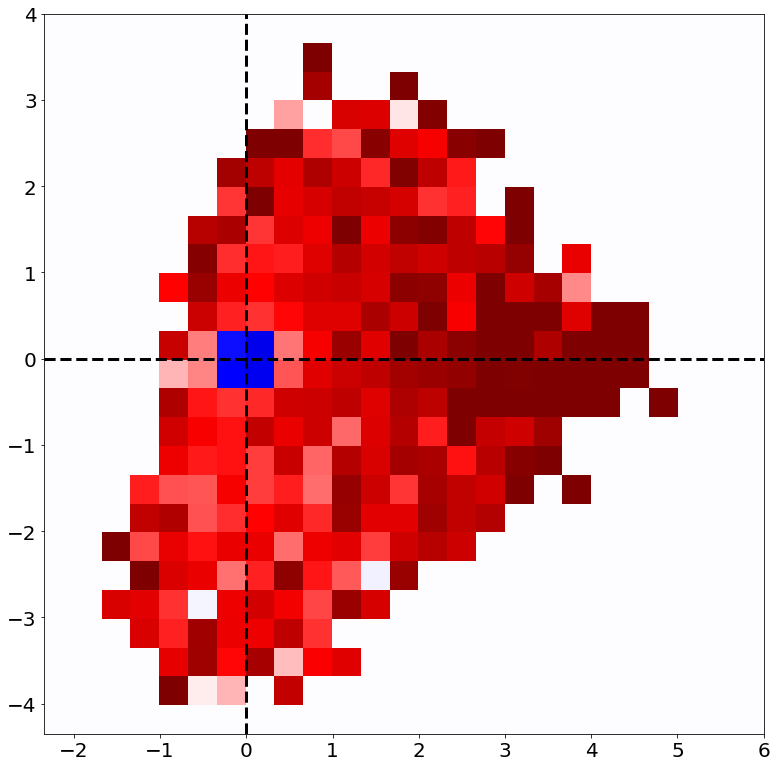

In [161]:
signal = temporal[:,0]
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])

#start_x=-2; end_x=6; start_y=-400; end_y=400
start_x=-2; end_x=6; start_y=-4; end_y=4

#ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
#ax.axvline(1.5,linestyle='--',color='k',linewidth=1)

fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                 num_bins_x=25, num_bins_y=25,
                                 start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                 min_num_samples=9)

fictrac_2d[-1,:] = 0
#fictrac_2d = gaussian_filter(fictrac_2d,sigma=.8)
h = ax.imshow(fictrac_2d[:,:],cmap='seismic_r',vmin=-5,vmax=5,extent=[-2.35,6,-4.35,4])
#fig.colorbar(h, ax=ax)

# fig, ax = plt.subplots()
# h = ax.hist2d(x, y, bins=40, norm=LogNorm())
# fig.colorbar(h[3], ax=ax)

# plt.scatter(X_var, Y_var, c=signal,s=1,cmap='seismic_r')
# plt.ylim(-1,1)
# plt.xlim(-1,1)

ax.axhline(0,linestyle='--',color='k',linewidth=3)
ax.axvline(0,linestyle='--',color='k',linewidth=3)

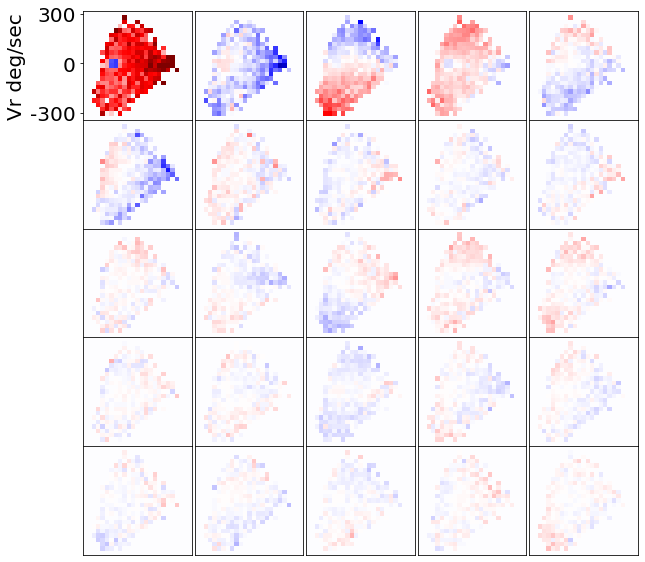

In [204]:
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
fig = plt.figure(figsize=(10,10))
#ax = fig.add_axes([0,0,1,1])
start_x=-2; end_x=6; start_y=-4; end_y=4

for k in range(25):
    signal = temporal[:,k]
    plt.subplot(5,5,k+1)
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0
    plt.imshow(fictrac_2d[:,:],cmap='seismic_r',vmin=-7,vmax=7,extent=[-2.35,6,-4.35,4])

    ax = plt.gca()
    if k == 0:
        
        ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
        ax.set_yticklabels([-300, 0, 300])
        ax.set_yticks([-300*ratio, 0, 300*ratio])

        ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
        ax.set_xticklabels([0, 10])
        ax.set_xticks([0, 10*ratio])

        plt.ylabel('Vr deg/sec')
        plt.xlabel('Vf mm/sec')
    else:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    #ax.axhline(0,linestyle='--',color='k',linewidth=1)
    #ax.axvline(0,linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(wspace=0, hspace=0)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [170]:
# want to have a given units value, say 300, and map to a std value
ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
300*ratio

3.799176468625893

In [166]:
np.max(behavior_super['Z_std'])

8.856727021425492

In [168]:
np.max(behavior_super['Z_units'])

591.7346020048824

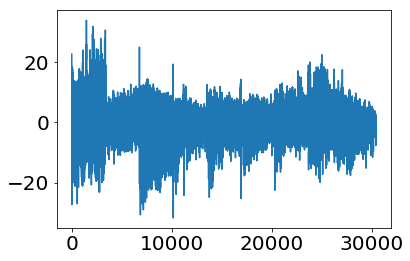

In [139]:
plt.plot(temporal[:,0])

In [143]:
np.mean(temporal[:,100])

1.3306203264276877e-08

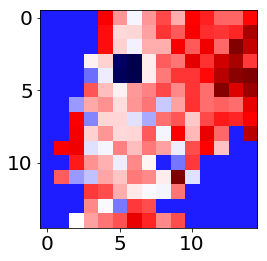

In [89]:
plt.imshow(fictrac_2d[:,:],cmap='seismic_r')

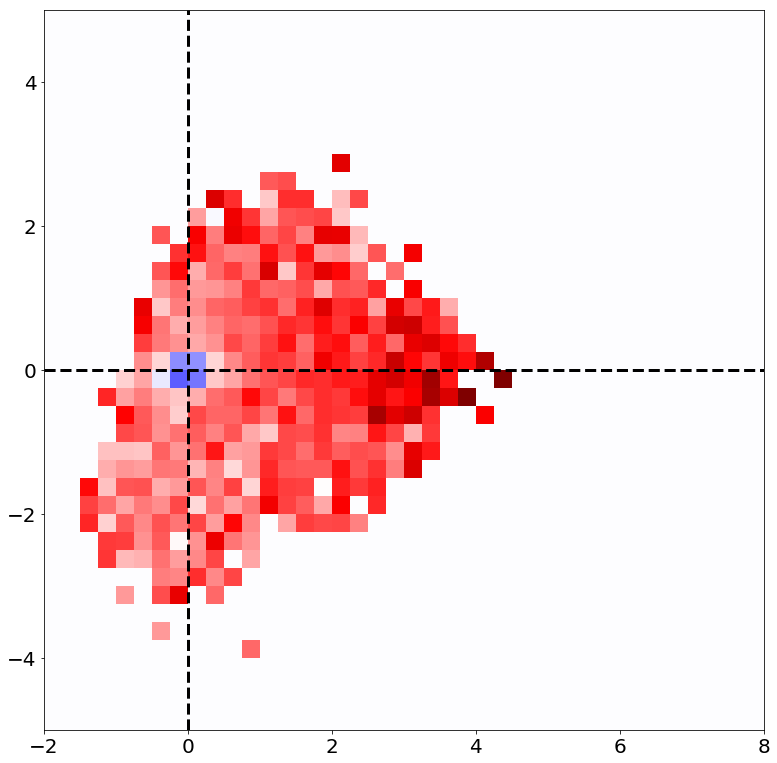

In [28]:
signal = temporal[:,0]
X_var = pooled_behavior['Y']
Y_var = pooled_behavior['Z']
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])

start_x=-1.7; end_x=8; start_y=-5; end_y=5.3
#ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
#ax.axvline(1.5,linestyle='--',color='k',linewidth=1)

fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                 num_bins_x=40, num_bins_y=40,
                                 start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                 min_num_samples=9)

#fictrac_2d = gaussian_filter(fictrac_2d,sigma=.8)
ax.imshow(fictrac_2d[:,:],cmap='seismic_r',vmin=-10,vmax=10,extent=[-2,8,-5,5])
ax.axhline(0,linestyle='--',color='k',linewidth=3)
ax.axvline(0,linestyle='--',color='k',linewidth=3)

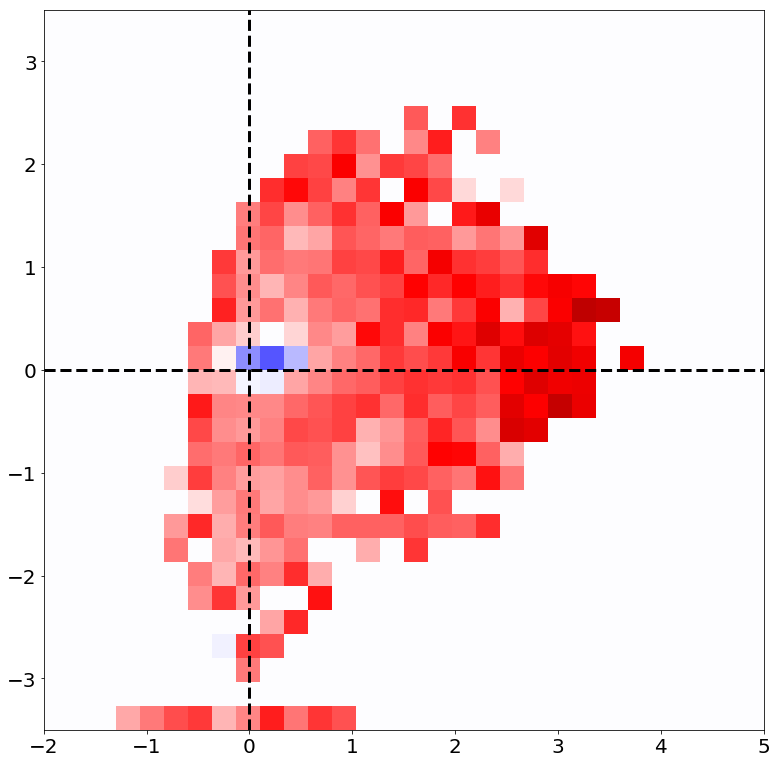

In [148]:
signal = temporal[:,0]
X_var = pooled_behavior['Y']
Y_var = pooled_behavior['Z']
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])

start_x=-2; end_x=5; start_y=-3.5; end_y=3.5
#ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
#ax.axvline(1.5,linestyle='--',color='k',linewidth=1)

fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                 num_bins_x=30, num_bins_y=30,
                                 start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                 min_num_samples=15)

#fictrac_2d = gaussian_filter(fictrac_2d,sigma=.8)
ax.imshow(fictrac_2d[:,:],cmap='seismic_r',vmin=-10,vmax=10,extent=[-2,5,-3.5,3.5])
ax.axhline(0,linestyle='--',color='k',linewidth=3)
ax.axvline(0,linestyle='--',color='k',linewidth=3)

In [152]:
bins_y

array([-3.5       , -3.25862069, -3.01724138, -2.77586207, -2.53448276,
       -2.29310345, -2.05172414, -1.81034483, -1.56896552, -1.32758621,
       -1.0862069 , -0.84482759, -0.60344828, -0.36206897, -0.12068966,
        0.12068966,  0.36206897,  0.60344828,  0.84482759,  1.0862069 ,
        1.32758621,  1.56896552,  1.81034483,  2.05172414,  2.29310345,
        2.53448276,  2.77586207,  3.01724138,  3.25862069,  3.5       ])

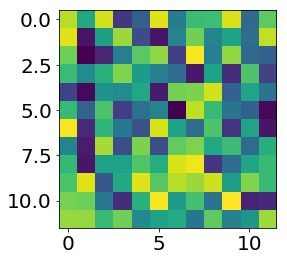

In [154]:
fig,ax = plt.subplots() 
N = 12 
ax.imshow(np.random.rand(N, N)) 
#seps = np.arange(-0.5, N) 
#ax.vlines(seps, -0.5, N - 0.5, linewidth=1)
#ax.hlines(seps, -0.5, N - 0.5, linewidth=1)
plt.show()

In [125]:
fictrac_2d.shape

(40, 40)

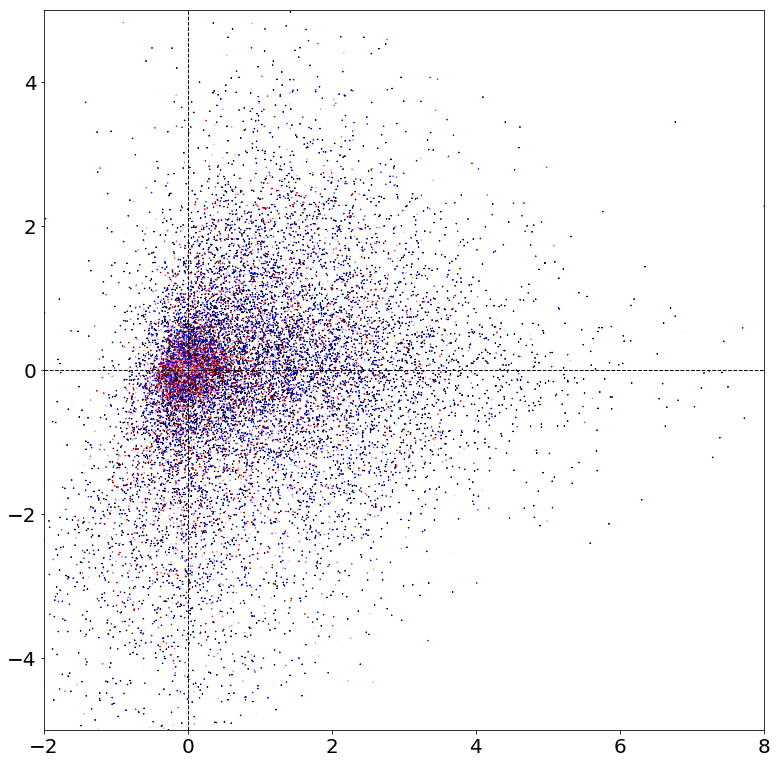

In [50]:
signal = temporal[:,0]
X_var = pooled_behavior['Y']
Y_var = pooled_behavior['Z']
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.set_ylim(-5,5)
ax.set_xlim(-2,8)

#start_x=-2; end_x=8; start_y=-5; end_y=5
ax.axhline(0,linestyle='--',color='k',linewidth=1)
ax.axvline(0,linestyle='--',color='k',linewidth=1)

ax.scatter(x=X_var,
           y=Y_var,
           c=signal,
           marker='x',cmap='seismic',vmin=-5,vmax=5,s=1,linewidth=1) #s,.2,lw=0

# fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
#                                  num_bins_x=20, num_bins_y=20,
#                                  start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y)

# ax.imshow(fictrac_2d,cmap='seismic',vmin=-1,vmax=1)